In [29]:
%matplotlib inline
import cv2
import sys
import os
import numpy as np
import json
from tqdm import tqdm
import base64
import matplotlib.pyplot as plt
import glob
import face_alignment
import time
import random
from collections import Counter
import numpy as np

import albumentations as A
from sklearn.model_selection import train_test_split

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2, ResNet50

from functools import partial
K.clear_session()

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback
from neptune.new.types import File

import sys
sys.path.append('../src')
from loss import *
from utils import *
from utils_cv import *

dir_data = '../data/json'
dir_res = '../data/res'
run = neptune.init(project="pacpac/ivy-DL",
                   api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiY2FiYjY1ZC02M2YxLTRlMmEtYTExYS03ODg0MGZjNDU0MTcifQ==",
                   tags=['phase 2.5','no image normalization', 'face_alignment', 'UNet_mobileNet', 'dice_loss', 'data augmentation', 'lw_1'],)

https://app.neptune.ai/pacpac/ivy-DL/e/IV-128
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Training parameters

In [2]:
img_size = (512, 512)
patience_early = 5
factor_reduce_lr = 0.1
patience_lr = 2
batch_size = 8
epoch = 25

run['params'] = {'img_size': img_size, 
                 'patience_early': patience_early,
                 'factor_reduce_lr': factor_reduce_lr,
                 'patience_lr': patience_lr,
                 'batch_size': batch_size,
                 'epoch': epoch,}

# Training data - front, smile & sides images

In [3]:
def process_label(img, tr, shapes, offset, axis, lw):
    # Transformation
    (h, w, top, bot, left, right, x_min, x_max, y_min, y_max) = tr
    # Label creation
    label = np.zeros((512,512, 3))
    for vrt in shapes:
        pts = np.array(vrt['points'])
        pts[:,axis] += np.floor(offset/2)
        
        pts[:,0] -= x_min
        pts[:,1] -= y_min
        pts/= h/512
        label = cv2.polylines(label, [pts.astype(np.int0)], 0, (255,255,255), lw)
        
    label = label[:,:,0].astype(np.uint8)
    label[label!=0] = 1
    
    return np.expand_dims(label, axis=-1)

In [4]:
# img_dataset = np.empty((len(json_list),*img_size,3)).astype(int)
# label_dataset = np.empty((len(json_list),*img_size,1)).astype(int)

# for idx, json_path in enumerate(tqdm(json_list)):

#     json_dict = json.load(open(json_path, 'r', encoding="utf-8_sig"))
#     im_bytes = base64.b64decode(json_dict['imageData'])
#     im_arr = np.frombuffer(im_bytes, dtype=np.uint8)  # im_arr is one-dim Numpy array
#     img = cv2.imdecode(im_arr, flags=cv2.IMREAD_COLOR)[:,:,[2,1,0]]
    
#     img, axis, offset = pad_img(img)
#     shapes = json_dict['shapes']
#     img_resize, tr, vis = process_input_image(img)
#     label = process_label(img_resize, tr, shapes, offset, axis, 1)
                         
#     img_dataset[idx,:,:,:] = img_resize
#     label_dataset[idx,:,:,:] = label

# with open('img_dataset_face_crop_512_2.5.npy', 'wb') as f:
#     np.save(f, img_dataset)
# with open('label_dataset_lw_1_512_2.5.npy', 'wb') as f:
#     np.save(f, label_dataset)

In [5]:
img_dataset = np.load(open('img_dataset_face_crop_512_2.5.npy', 'rb'))
label_dataset = np.load(open('label_dataset_lw_1_512_2.5.npy', 'rb'))
print(img_dataset.shape, label_dataset.shape)

(983, 512, 512, 3) (983, 512, 512, 1)


# Vis

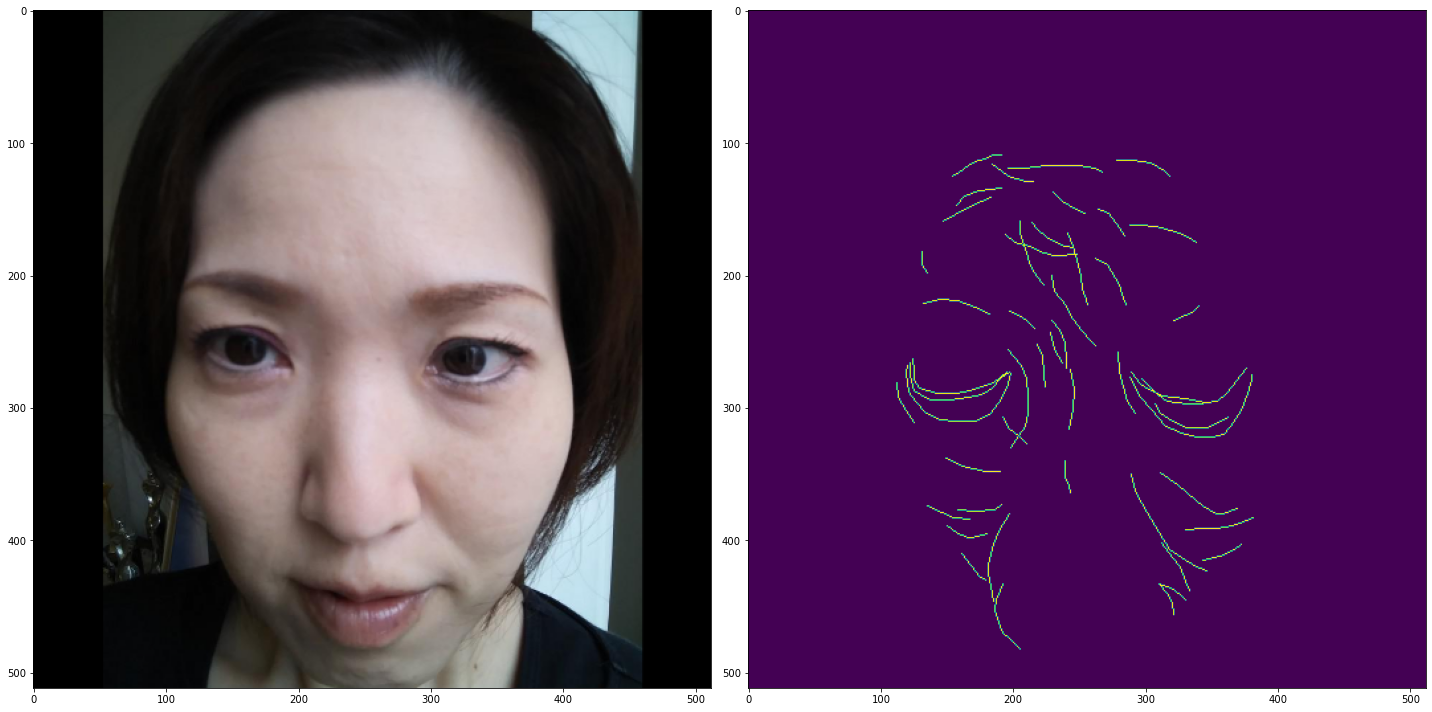

In [30]:
idx = 0
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(img_dataset[idx])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(label_dataset[idx]))

plt.tight_layout()
plt.show()

In [7]:
s = 0
X, X_test, y, y_test = train_test_split(img_dataset,
                                        label_dataset,
                                        test_size=0.2,
                                        random_state=s)
print(X.shape, y.shape, X_test.shape, y_test.shape)

(786, 512, 512, 3) (786, 512, 512, 1) (197, 512, 512, 3) (197, 512, 512, 1)


# Data augmentation

In [8]:
# Declare an augmentation pipeline
transform = A.Compose([A.Flip(p=0.5),
                       A.ShiftScaleRotate(shift_limit=0.1,
                                          scale_limit=0,
                                          rotate_limit=10,
                                          interpolation=1,
                                          border_mode=0,
                                          value=(0,0,0),
                                          mask_value=0,
                                          shift_limit_x=None,
                                          shift_limit_y=None,
                                          always_apply=False,
                                          p=0.5),
                       A.ChannelShuffle(p=0.25),])

# Data augmentation
k = 1
n = X.shape[0]
X_aug = np.empty((k*n, *img_size, 3)).astype(int)
y_aug = np.empty((k*n, *img_size, 1)).astype(int)

for seed in range(k):
    random.seed(seed)
    for idx, (image, mask) in enumerate(tqdm(list(zip(X, y)))):
        transformed = transform(image=image.astype(np.uint8),
                                mask=mask.astype(np.uint8))
        X_aug[(seed*n)+idx,:,:,:] = transformed["image"]
        y_aug[(seed*n)+idx,:,:,:] = transformed["mask"]

X_aug = np.vstack((X, X_aug)).astype(int)
y_aug = np.vstack((y, y_aug)).astype(float)
print(X_aug.shape, y_aug.shape)

100%|███████████████████████████████████████████████████████████████████████████████| 786/786 [00:02<00:00, 334.32it/s]


(1572, 512, 512, 3) (1572, 512, 512, 1)


# Visualization

In [9]:
idx = 800
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(X_aug[idx])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(y_aug[idx]))

plt.tight_layout()
plt.show()

In [10]:
unique, cnt = np.unique(label_dataset.astype(int), return_counts = True)
print(unique, cnt/np.sum(cnt))

[0 1] [0.99362789 0.00637211]


# Data split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, test_size=0.25, random_state=s)

run['split_random_state'] = seed
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1179, 512, 512, 3) (1179, 512, 512, 1) (393, 512, 512, 3) (393, 512, 512, 1) (197, 512, 512, 3) (197, 512, 512, 1)


In [12]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_resnet50_unet(input_shape):
    """ Input """
    inputs = Input((*input_shape, 3))

    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    
    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           ## (512 x 512)
    s2 = resnet50.get_layer("conv1_relu").output        ## (256 x 256)
    s3 = resnet50.get_layer("conv2_block3_out").output  ## (128 x 128)
    s4 = resnet50.get_layer("conv3_block4_out").output  ## (64 x 64)

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  ## (32 x 32)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
    d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
    d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
    d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ResNet50_U-Net")
    return model

# Training

In [13]:
metrics = ["acc", iou, dice_coef, tversky]

model = build_resnet50_unet(img_size)
model.compile(optimizer="adam",
              loss=dice_coef_loss,
              metrics=metrics)

In [14]:
neptune_cbk = NeptuneCallback(run=run, base_namespace="metrics")
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=patience_early)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=factor_reduce_lr, patience=patience_lr)
callbacks_list = [early_stop, reduce_lr, neptune_cbk]

history = model.fit(X_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=epoch,
                    verbose="auto",
                    callbacks=callbacks_list,
                    validation_data=(X_val, y_val),)

model.save("resnet_unet_data_augmentation_lw_1_2.5.h5")

Epoch 1/25
148/148 [==============================] - 8055s 54s/step - loss: 0.9155 - acc: 0.9166 - iou: 0.0447 - dice_coef: 0.0848 - tversky: 0.1139 - val_loss: 0.9876 - val_acc: 0.0456 - val_iou: 0.0062 - val_dice_coef: 0.0123 - val_tversky: 0.0204 - lr: 0.0010
Epoch 2/25
148/148 [==============================] - 8180s 55s/step - loss: 0.8500 - acc: 0.9847 - iou: 0.0811 - dice_coef: 0.1497 - tversky: 0.1708 - val_loss: 0.8763 - val_acc: 0.9852 - val_iou: 0.0655 - val_dice_coef: 0.1228 - val_tversky: 0.1397 - lr: 0.0010
Epoch 3/25
148/148 [==============================] - 8175s 55s/step - loss: 0.8307 - acc: 0.9858 - iou: 0.0927 - dice_coef: 0.1694 - tversky: 0.1899 - val_loss: 0.9052 - val_acc: 0.9900 - val_iou: 0.0492 - val_dice_coef: 0.0935 - val_tversky: 0.0918 - lr: 0.0010
Epoch 4/25
148/148 [==============================] - 8192s 55s/step - loss: 0.8240 - acc: 0.9863 - iou: 0.0966 - dice_coef: 0.1759 - tversky: 0.1951 - val_loss: 0.9418 - val_acc: 0.9932 - val_iou: 0.0297 - v

# Training metrics

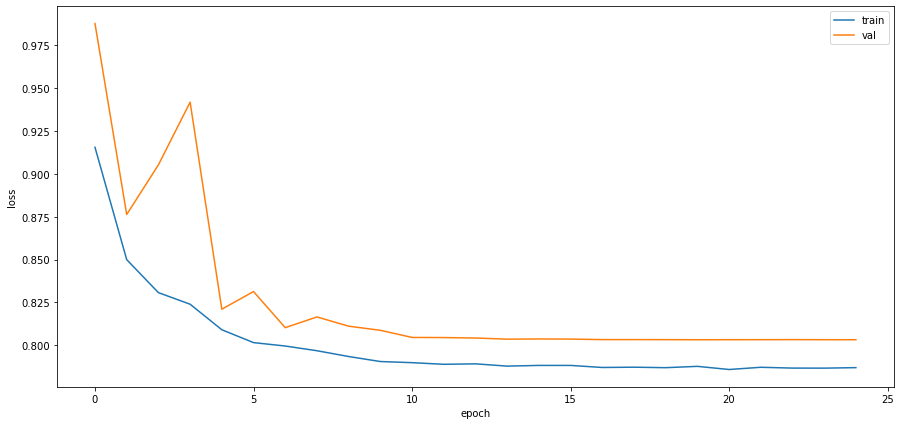

In [17]:
%matplotlib inline
fig = plt.figure(figsize=(15,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper right')
plt.show()

run["visuals/training_metrics"] = File.as_html(fig)

In [18]:
from tensorflow import keras
model = keras.models.load_model('resnet_unet_data_augmentation_lw_1_2.5.h5', custom_objects={'dice_coef_loss': dice_coef_loss,
                                                                                             'dice_coef': dice_coef,
                                                                                             'focal_tversky_loss':focal_tversky_loss,
                                                                                             'tversky_loss':tversky_loss,
                                                                                             'tversky':tversky,
                                                                                             'iou':iou})
t = time.time()
preds = model.predict(X_test)
e = time.time()
print(e - t)

284.16251969337463


In [20]:
def plot_results(img_ds, label_ds, pred_ds, idx, tr_ds = None):
    img = img_ds[idx].astype(int)
    gt = np.squeeze(label_ds[idx].astype(int))
    if tr_ds is None:
        mask = np.squeeze(preds[idx])
    else:
        mask = adjust_mask_pred(pred_ds[idx], tr_ds[idx][0])
    
    img_mask = img.copy()
    img_mask[np.rint(mask).astype(bool)] = [202,184,217]

    img_gt = img.copy()
    img_gt[gt.astype(bool)] = [0,0,255]

    fig = plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(img_gt)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(img_mask)
    plt.axis('off')
    plt.tight_layout()
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    vis = data.reshape((int(h), int(w), -1))
    
    plt.close()
    
    pix = np.where(vis!=255)
    x1, x2 = np.min(pix[1]), np.max(pix[1])
    y1, y2 = np.min(pix[0]), np.max(pix[0])
    
    return vis[y1:y2,x1:x2]

# Inference on front test data

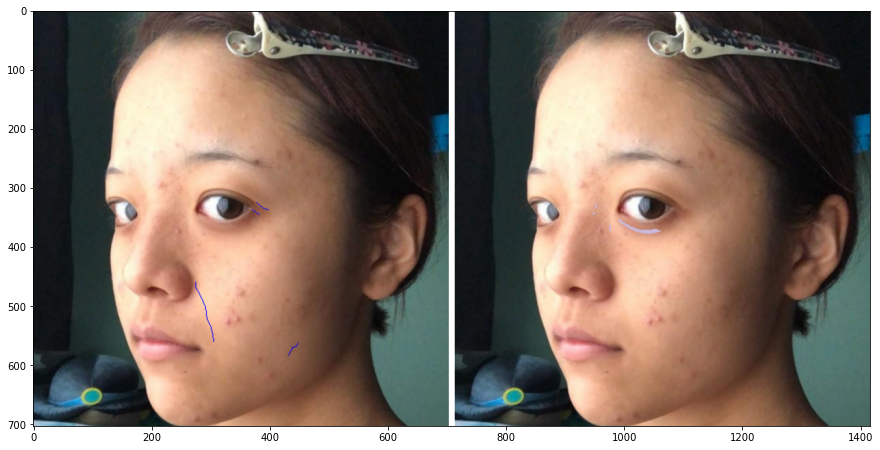

In [27]:
idx = 6
vis_test = plot_results(X_test, y_test, preds, idx)

plt.figure(figsize=(15,15))
plt.imshow(vis_test)
plt.show()

# Saving test data

In [28]:
for idx in tqdm(range(X_test.shape[0])):
    vis_test = plot_results(X_test, y_test, preds, idx)
    cv2.imwrite('../data/dice/test_picture_%s.png'%(idx), vis_test[:,:,[2,1,0]])

100%|████████████████████████████████████████████████████████████████████████████████| 197/197 [00:45<00:00,  4.29it/s]


# Evaluation on front test data

In [ ]:
iou_eval = []
for idx, _ in enumerate(tqdm(range(X_test.shape[0]))):
    m = np.squeeze(preds[idx].astype(int))
    g = np.squeeze(y_test[idx]).astype(int)
    iou_eval.append(iou_mask(g, m))

np.mean(iou_eval)